In [200]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from quantbullet import set_figsize
import quantbullet.research.jump_model as jm
from quantbullet.research.momentum import (
    compute_ex_ante_volatility, 
    generate_ts_momentum_signal,
)
from quantbullet.utils import (
    plot_price_logret_volatility,
    plot_price_with_signal,
    plot_shared_x
)

import importlib
import quantbullet.research.momentum
importlib.reload(quantbullet.research.momentum)

<module 'quantbullet.research.momentum' from '/home/yimingz/dev/quantbullet/src/quantbullet/research/momentum.py'>

In [81]:
import importlib
import quantbullet.utils
importlib.reload(quantbullet.utils)

<module 'quantbullet.utils' from '/home/yiming/dev/quantbullet/src/quantbullet/utils/__init__.py'>

In [27]:
# activate the autoreload of modules
%load_ext autoreload
%autoreload 2

In [5]:
import yfinance as yf
# Define the ticker symbol
ticker_symbol = "TSLA"
# Fetch data
data = yf.download(ticker_symbol, start="2018-01-01", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed


In [6]:
log_ret = compute_log_returns(data['Adj Close'])
exante_vol = compute_ex_ante_volatility(log_ret)

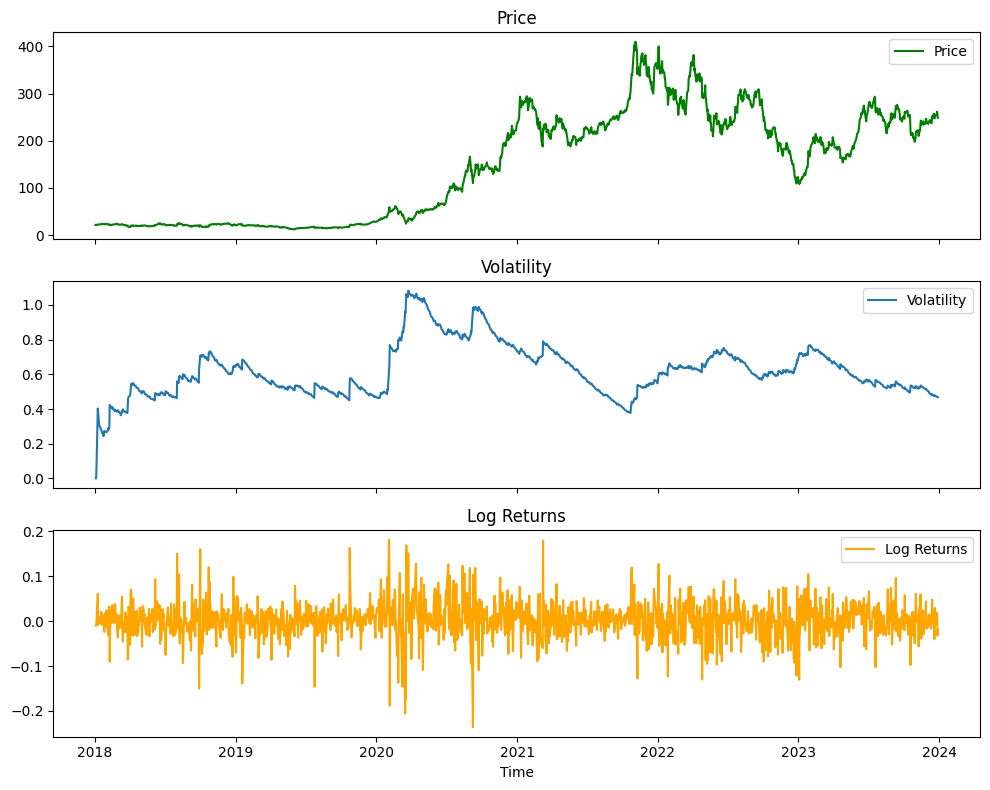

In [7]:
plot_price_logret_volatility(data['Adj Close'], log_ret, exante_vol);

## Use 2018-2020 data to model the parameters

In [23]:
price = data['Adj Close']
train_price = price[:'2020-12-31']
test_price = price['2021-01-01':]
log_ret = compute_log_returns(data['Adj Close'])
train_ret = log_ret[:'2020-12-31']
test_ret = log_ret['2021-01-01':]

In [15]:
enriched_returns = jm.FeatureGenerator().enrich_features(train_ret)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)

In [16]:
ctsJump = jm.ContinuousJumpModel()
best_states, best_loss, best_thetas = ctsJump.fit(enriched_returns, k=2, lambda_=100, n_trials=10)

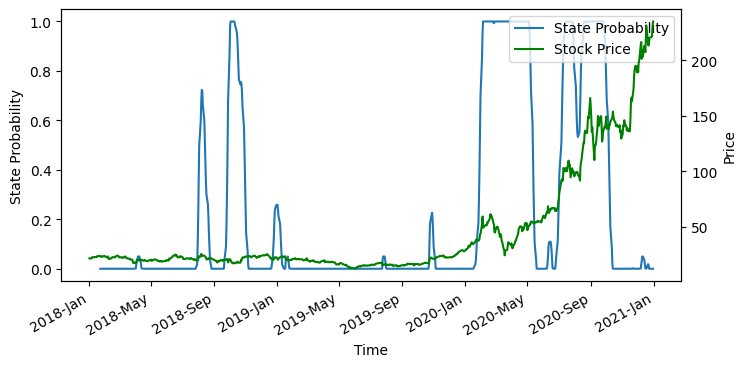

In [17]:
remapped_states, remapped_thetas = jm.arrange_state_prob_by_volatility(enriched_returns[:, 0], best_states, best_thetas, 0.5)
with set_figsize(8, 4):
    # Two states maybe flipped, so we need to rearrange them
    jm.TestingUtils().plot_state_probs(remapped_states, data['Adj Close'][:'2020-12-31'])

## Test the 2021-2023 data

In [18]:
enriched_returns = jm.FeatureGenerator().enrich_features(test_ret)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)

In [107]:
test_probs = ctsJump.predict(enriched_returns, 
                             remapped_thetas, 
                             lambda_=10)

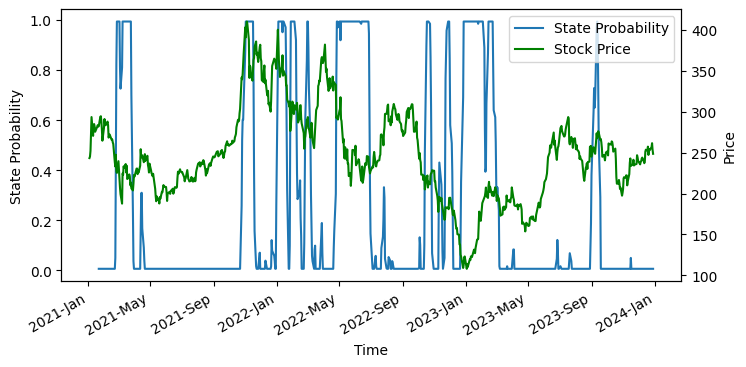

In [108]:
with set_figsize(8, 4):
    jm.TestingUtils().plot_state_probs(test_probs,
                                       test_price)

The prediction does not seem to identify same pattern every time up or down, though I do think it captured the unilateral (one-sided) market. From the volatility chart below, we see the model seems to predict well for a volatility spike.

The sharp increase in volatility may be associated with a market crash / market surge, so we see unilateral movement in the market. These observations may support a momentum strategy.

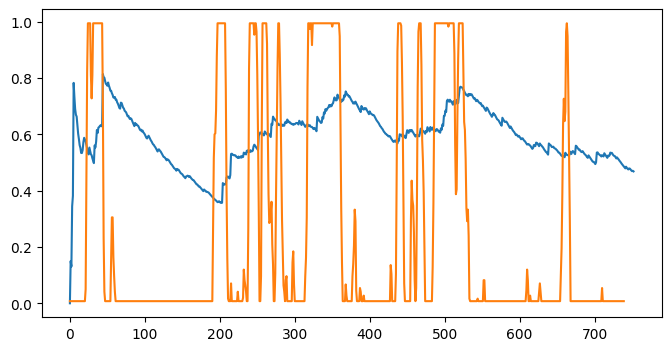

In [39]:
exante_vol = compute_ex_ante_volatility(test_ret)
with set_figsize(8, 4):
    plt.plot(exante_vol.values);
    plt.plot(test_probs[:, 1]);

In [125]:
test_momentum_signal = generate_ts_momentum_signal(test_ret, 10)

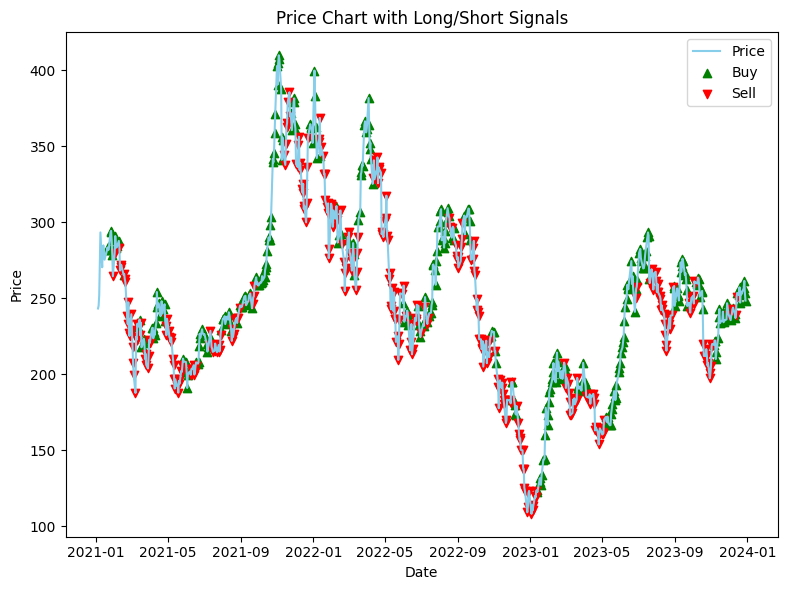

In [126]:
plot_price_with_signal(test_price, test_momentum_signal, figsize=(8, 6));

# Returns of the momentum strategy under regimes

In [127]:
if not isinstance(test_probs, pd.Series):
    test_probs = pd.Series(test_probs[:, 1], index=test_momentum_signal.index[13:])

In [152]:
df = pd.DataFrame({'ts_momentum_signal': test_momentum_signal,
                   'close': test_price,
                   'state_probs': test_probs,
                   'log_return': test_ret,
                   'volatility': exante_vol,
                   'return': np.exp(test_ret) - 1})

In [153]:
df['momentum_return'] = df['ts_momentum_signal'] * df['return']
df['momentum_cum_return'] = (1 + df['momentum_return']).cumprod()
df['state_0_momentum_return'] = df['ts_momentum_signal'] * df['return'] * np.where(df['state_probs'] < 0.5, 1, np.nan)
df['state_0_momentum_cum_return'] = (1 + df['state_0_momentum_return'].fillna(0)).cumprod()
df['state_1_momentum_return'] = df['ts_momentum_signal'] * df['return'] * np.where(df['state_probs'] >= 0.5, 1, np.nan)
df['state_1_momentum_cum_return'] = (1 + df['state_1_momentum_return'].fillna(0)).cumprod()

In [154]:
def compute_sharpe_ratio(returns, annualization_factor=252):
    return np.sqrt(annualization_factor) * returns.mean() / returns.std()

def compute_max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    return (cum_returns / cum_returns.cummax() - 1).min()

def print_metrics(returns, annualization_factor=252):
    print(f'Annualized Return: {returns.mean() * annualization_factor:.2%}')
    print(f'Annualized Volatility: {returns.std() * np.sqrt(annualization_factor):.2%}')
    print(f'Sharp Ratio: {compute_sharpe_ratio(returns, annualization_factor):.2f}')
    print(f'Max Drawdown: {compute_max_drawdown(returns):.2%}')
    print(f'Number of Trades: {returns[returns != 0].count()}')

In [155]:
print_metrics(df['momentum_return'])

Annualized Return: 45.22%
Annualized Volatility: 58.55%
Sharp Ratio: 0.77
Max Drawdown: -52.79%
Number of Trades: 742


In [156]:
print_metrics(df['state_0_momentum_return'])

Annualized Return: 57.84%
Annualized Volatility: 49.67%
Sharp Ratio: 1.16
Max Drawdown: -38.58%
Number of Trades: 561


In [157]:
print_metrics(df['state_1_momentum_return'])

Annualized Return: 3.19%
Annualized Volatility: 80.69%
Sharp Ratio: 0.04
Max Drawdown: -60.66%
Number of Trades: 178


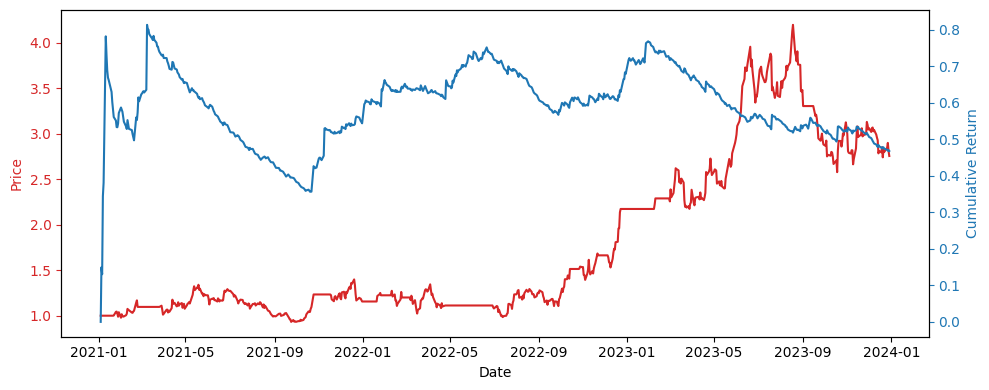

In [162]:
with set_figsize(10, 4):
    plot_shared_x(
        df.index,
        df['state_0_momentum_cum_return'],
        df['volatility'],
        xlabel='Date',
        ylabel1='Price',
        ylabel2='Cumulative Return',
    );

## Mean Reversion Strategy

In [57]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from collections import namedtuple
import matplotlib.pyplot as plt
import quantbullet as qb

%load_ext autoreload
%autoreload 2

# import quantbullet as qb
# import importlib
# importlib.reload(qb)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ff5 = pd.read_pickle('fama_french_five_factors_20180101_20231231.pkl')
tsla = pd.read_pickle('tsla_20180101_20231231.pkl')['Adj Close']

In [4]:
tsla_log_ret = qb.compute_log_returns(tsla)
calendar = qb.BacktestingCalendar(tsla.index)
ff5_provider = qb.SimpleDataProvider(ff5)
tsla_provider = qb.SimpleDataProvider(tsla_log_ret)

In [5]:
res = list()
OFFSET_DAYS = 152
calendar.set_current_date(datetime.date(2019, 1, 4))
OBS = namedtuple('OBS', ['date', 'resid', 'rsquared', 'f_pvalue'])
for date in calendar:
    backtest_start = calendar.get_offset_date(-OFFSET_DAYS)
    backtest_end = date
    X = ff5_provider.get_historical_data(backtest_start, backtest_end)
    y = tsla_provider.get_historical_data(backtest_start, backtest_end)
    model = qb.ols_regression(X, y)
    obs = OBS(date=date,
              resid=model.resid.loc[date], 
              rsquared=model.rsquared, 
              f_pvalue=model.f_pvalue)
    res.append(obs)

In [6]:
df = pd.DataFrame(res, columns=OBS._fields).set_index('date')
df['cum_excess_return'] = (1 + df['resid']).cumprod()

In [7]:
cum_excess_return = df['cum_excess_return']
calendar = qb.BacktestingCalendar(cum_excess_return.index)
excess_return_provider = qb.SimpleDataProvider(cum_excess_return)

In [8]:
res = list()
OFFSET_DAYS = 252
calendar.set_current_date(datetime.date(2021, 1, 4))
OBS = namedtuple("OBS", ["date", "mu", "theta", "sigma"])
for date in calendar:
    backtest_start = calendar.get_offset_date(-OFFSET_DAYS)
    backtest_end = date
    X = excess_return_provider.get_historical_data(backtest_start, backtest_end)
    model = qb.OrnsteinUhlenbeck()
    model.fit(X)
    obs = OBS(date=date, mu=model.mu, theta=model.theta, sigma=model.sigma)
    res.append(obs)

In [32]:
tsdf = pd.DataFrame(res, columns=OBS._fields).set_index('date')
tsdf = model.generate_bands(tsdf, 1.96)
tsdf['original'] = cum_excess_return

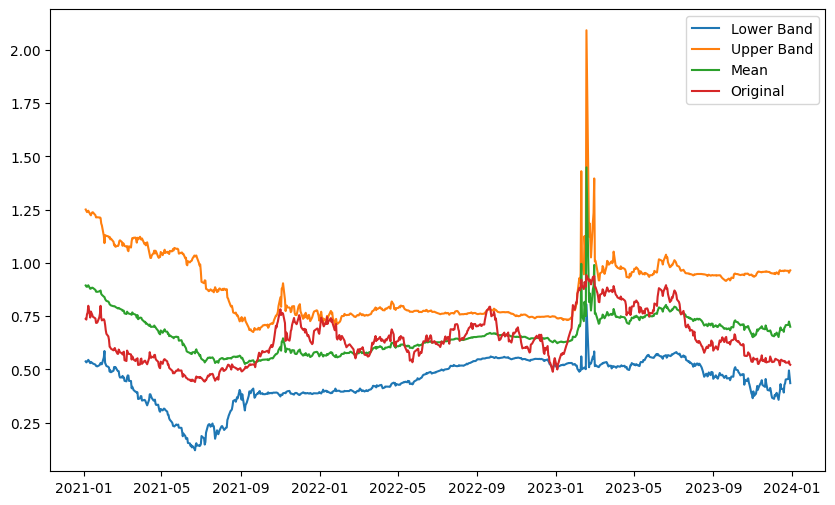

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tsdf['lower_band'], label='Lower Band')
ax.plot(tsdf['upper_band'], label='Upper Band')
ax.plot(tsdf['mu'], label='Mean')
ax.plot(tsdf['original'], label='Original')
plt.legend()

In [34]:
tsdf['signal'] = np.where(tsdf['original'] >= tsdf['upper_band'], -1, np.nan)
tsdf['signal'] = np.where(tsdf['original'] <= tsdf['lower_band'], 1, tsdf['signal'])

In [56]:
type(tsdf['signal'].iloc[1])

numpy.float64

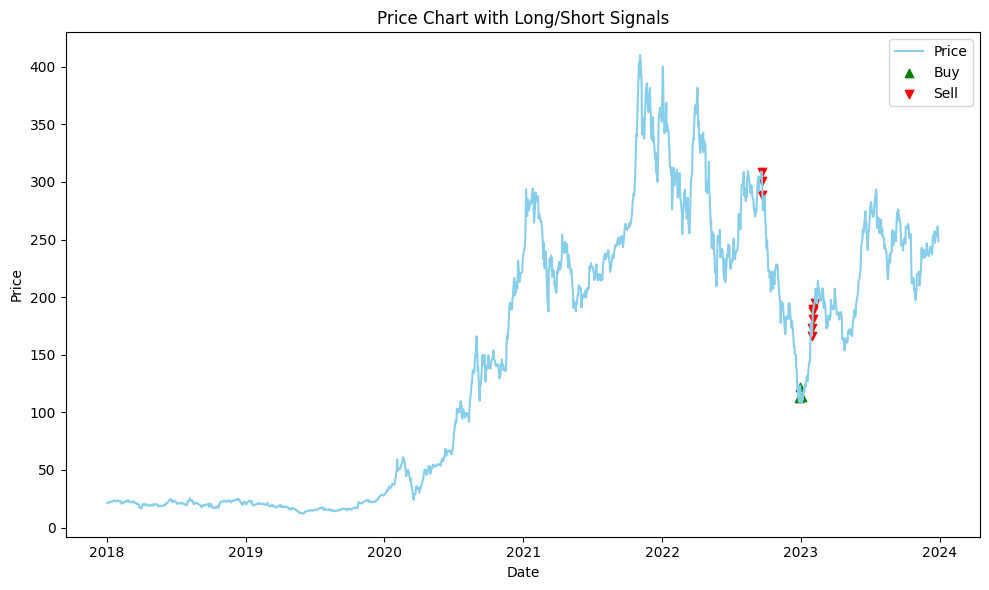

In [60]:
qb.plot_price_with_signal(tsla, tsdf['signal'].shift(1), figsize=(10, 6));

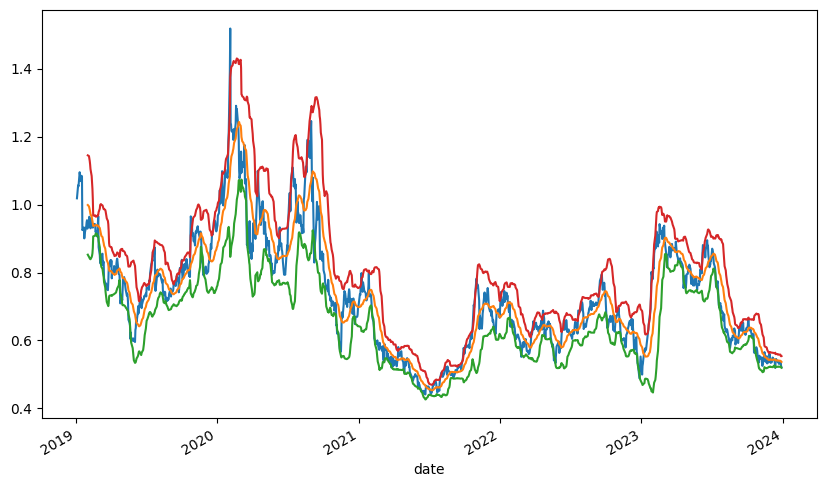

In [281]:
cum_excess_return.plot(label='Cumulative Excess Return', figsize=(10, 6))
cum_excess_return.rolling(20).mean().plot(label='20-day Moving Average')
vol = cum_excess_return.rolling(20).std()
# plot mean - 2 * vol
(cum_excess_return.rolling(20).mean() - 2 * vol).plot(label='Lower Bound')
# plot mean + 2 * vol
(cum_excess_return.rolling(20).mean() + 2 * vol).plot(label='Upper Bound')
signal = np.where(cum_excess_return >= cum_excess_return.rolling(20).mean() + 2 * vol, -1, np.nan)
signal = np.where(cum_excess_return <= cum_excess_return.rolling(20).mean() - 2 * vol, 1, signal)

In [285]:
cum_excess_return.shape

(1256,)

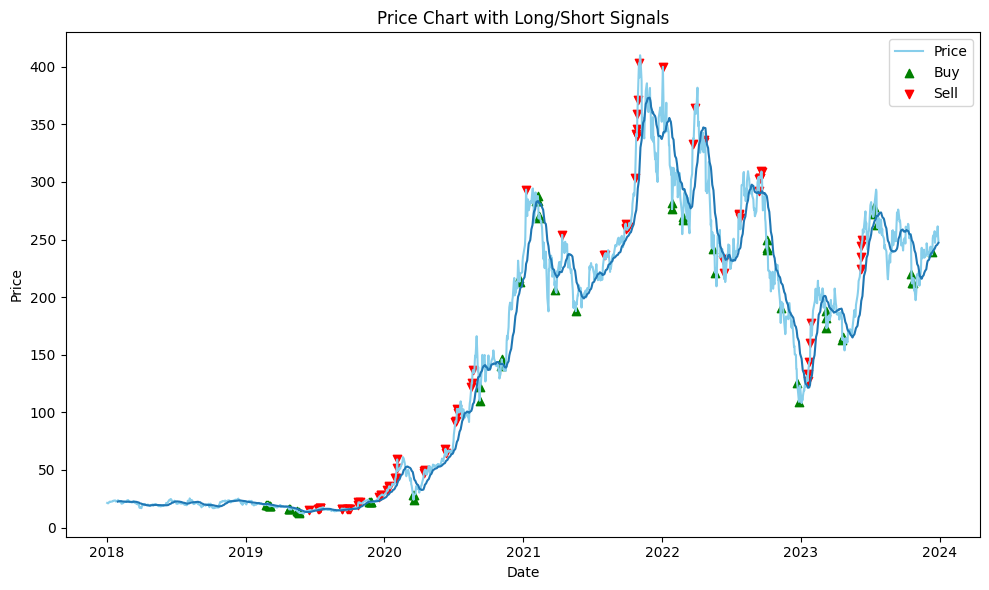

In [299]:
fig, ax = plot_price_with_signal(tsla, pd.Series(signal, index=cum_excess_return.index), figsize=(10, 6))
ax.plot(tsla.rolling(20).mean(), label='20-day Moving Average')